In [1]:
# Header from RIT notebook
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
##Setting up Google sdk environment
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/marcelkc/.config/gcloud/application_default_credentials.json' 
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-nigam-starr' #som-nero-phi-rit
%load_ext google.cloud.bigquery
##Setting up BQ API
from google.cloud import bigquery
client=bigquery.Client()

/share/sw/open/anaconda/3/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [2]:
query = """SELECT 
v.person_id, 
visit_start_DATETIME, 
ARI_symptoms_2_months, 
race_concept_id, ethnicity_concept_id, # race/ethnicity
gender_concept_id, # gender
year_of_birth, month_of_birth, day_of_birth, # age at present
visit_concept_id, care_site_name, # location
value_source_value, # test result
visit_occurrence_id
FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.visit_occurrence` v

LEFT JOIN(
  #visit_occurrence_id (unique) to ARI_symptoms
  SELECT 
  visit_occurrence_id,
  #ARI symptoms # any condition_start_DATETIME, condition_end_DATETIME within 2 months
  max(
  DATETIME_DIFF(visit_start_DATETIME, condition_start_DATETIME, MONTH) < 2
  OR
  DATETIME_DIFF(visit_start_DATETIME, condition_end_DATETIME, MONTH) < 2 
  )
  AS ARI_symptoms_2_months,
  FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.visit_occurrence` v
  LEFT JOIN (
    SELECT person_id, condition_start_DATETIME, condition_end_DATETIME, 
    condition_source_value, condition_source_concept_id # might get used later
    FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.condition_occurrence`
    WHERE (condition_start_DATETIME >= '2019-11-01T00:00:00.000' OR condition_end_DATETIME >= '2019-11-01T00:00:00.000')
    AND
    (condition_source_value LIKE 'J00.%' OR
    condition_source_value LIKE 'J01.%' OR
    condition_source_value LIKE 'J02.%' OR
    condition_source_value LIKE 'J03.%' OR
    condition_source_value LIKE 'J04.%' OR
    condition_source_value LIKE 'J05.%' OR
    condition_source_value LIKE 'J06.%' OR
    condition_source_value LIKE 'J09.%' OR
    condition_source_value LIKE 'J10.%' OR
    condition_source_value LIKE 'J11.%' OR
    condition_source_value LIKE 'J12.%' OR
    condition_source_value LIKE 'J13.%' OR
    condition_source_value LIKE 'J14.%' OR
    condition_source_value LIKE 'J15.%' OR
    condition_source_value LIKE 'J16.%' OR
    condition_source_value LIKE 'J17.%' OR
    condition_source_value LIKE 'J18.%' OR
    condition_source_value LIKE 'J20.%' OR
    condition_source_value LIKE 'J21.%' OR
    condition_source_value LIKE 'J22' OR
    condition_source_value LIKE 'J80' OR
    condition_source_value LIKE 'A37.91' OR
    condition_source_value LIKE 'A37.01' OR
    condition_source_value LIKE 'A37.11' OR
    condition_source_value LIKE 'A37.81' OR
    condition_source_value LIKE 'A48.1' OR
    condition_source_value LIKE 'B25.0' OR
    condition_source_value LIKE 'B44.0' OR
    condition_source_value LIKE 'B97.4' OR
    condition_source_value LIKE 'U07.1')
  ) USING (person_id)
  WHERE visit_start_DATETIME >= '2020-02-01T00:00:00.000' # all encounters from feb 1
  GROUP BY visit_occurrence_id
  )
USING (visit_occurrence_id)


LEFT JOIN (
  # visit_occurrence_id to covid test result (value_source_value) 
  SELECT value_source_value, # test result
  visit_occurrence_id # for mapping(s)
  FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.measurement`
  WHERE measurement_concept_id = 706170
) 
USING (visit_occurrence_id)

INNER JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.person` USING (person_id)

LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.care_site` c  
ON c.care_site_id = v.care_site_id

WHERE visit_start_DATETIME >= '2020-02-01T00:00:00.000' # all encounters from feb 1"""
query_job = client.query(query)
df = query_job.to_dataframe(progress_bar_type='tqdm')

Downloading: 100%|██████████| 1835715/1835715 [03:44<00:00, 7912.41rows/s]


In [3]:
df.to_csv("long_table_cdc.csv", sep=';')
df.head()

,person_id,visit_start_DATETIME,ARI_symptoms_2_months,race_concept_id,ethnicity_concept_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,visit_concept_id,care_site_name,value_source_value,visit_occurrence_id
0,31449046,2020-02-21,None,8527,38003564,8532,1930,4,29,0,RADIOLOGY STANFORD HOSPITAL DIAGNOSTIC,None,159169916
1,31449046,2020-04-11,None,8527,38003564,8532,1930,4,29,0,RADIOLOGY DIAGNOSTIC 1ST FLOOR - 500P,None,163698599
2,32536564,2020-02-18,True,8527,38003564,8532,1932,9,9,0,CCSB THIRD FLOOR CLINIC,None,160673028
3,32135543,2020-03-17,False,8527,38003564,8532,1930,12,5,0,GASTROENTEROLOGY VCL 1133 207,None,160992998
4,30291433,2020-03-12,None,8527,38003564,8507,1931,2,23,0,RADIOLOGY CT 1ST FLOOR - 500P,None,160546382


In [4]:
import numpy as np
import pandas as pd
# positive_test
positive_value_source_value = lambda x: x in ['Detected', 'DETECTED', 'Pos']
pos_test_bool = df['value_source_value'].apply(positive_value_source_value).rename('positive')
# tested
test_bool = df['value_source_value'].notnull().rename('tested')
# ARI_sympt
ARI_2_mon = df['ARI_symptoms_2_months'] == True
ARI_2_mon = ARI_2_mon.rename('ARI_symptoms_2_months_bool')
# age results
visit_dt = df['visit_start_DATETIME'].apply(lambda x : pd.to_datetime(x))
pat_bd_dt = df[['year_of_birth', 'month_of_birth', 'day_of_birth']].apply(lambda x: pd.to_datetime('-'.join([str(i) for i in x])), axis=1)
pat_age = visit_dt - pat_bd_dt
pat_age = pat_age.apply(lambda x: x.days/365.25).rename('age')
# age categorical
bins = [0, 5, 18, 50, 65, 75, 85, 100]
labels = ["[{0}, {1})".format(i, j) for i, j in zip(bins[:-1], bins[1:])]
age_cat = pd.cut(pat_age, bins, labels=labels)

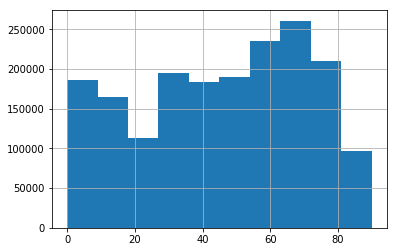

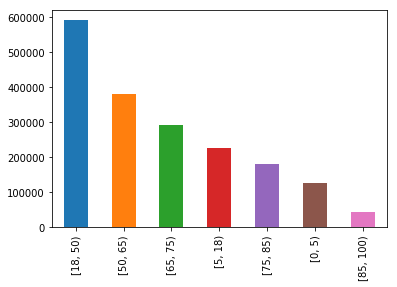

In [5]:
# for all "visits" since February
plt.figure()
pat_age.hist()
plt.figure()
age_cat.value_counts().plot(kind='bar')

In [6]:
df_all = pd.concat([pos_test_bool, test_bool, age_cat, df, ARI_2_mon], axis=1)
df_all['total'] = 1
df_all.head()

,positive,tested,age,person_id,visit_start_DATETIME,ARI_symptoms_2_months,race_concept_id,ethnicity_concept_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,visit_concept_id,care_site_name,value_source_value,visit_occurrence_id,ARI_symptoms_2_months_bool,total
0,False,False,"[85, 100)",31449046,2020-02-21,None,8527,38003564,8532,1930,4,29,0,RADIOLOGY STANFORD HOSPITAL DIAGNOSTIC,None,159169916,False,1
1,False,False,"[85, 100)",31449046,2020-04-11,None,8527,38003564,8532,1930,4,29,0,RADIOLOGY DIAGNOSTIC 1ST FLOOR - 500P,None,163698599,False,1
2,False,False,"[85, 100)",32536564,2020-02-18,True,8527,38003564,8532,1932,9,9,0,CCSB THIRD FLOOR CLINIC,None,160673028,True,1
3,False,False,"[85, 100)",32135543,2020-03-17,False,8527,38003564,8532,1930,12,5,0,GASTROENTEROLOGY VCL 1133 207,None,160992998,False,1
4,False,False,"[85, 100)",30291433,2020-03-12,None,8527,38003564,8507,1931,2,23,0,RADIOLOGY CT 1ST FLOOR - 500P,None,160546382,False,1


In [7]:
def visualize_col(df, col_nm):
    print(df[col_nm].value_counts())
    
    plt.figure()
    df[col_nm].value_counts().plot(kind='bar')
    
    tbl = pd.pivot_table(df, values=['tested', 'positive', 'total', 'ARI_symptoms_2_months_bool'], index=['visit_concept_id'],
                        columns=[col_nm], aggfunc=np.sum)
    return tbl.T

In [8]:
df_all.isnull().sum()

positive                            0
tested                              0
age                              1722
person_id                           0
visit_start_DATETIME                0
ARI_symptoms_2_months         1647891
race_concept_id                     0
ethnicity_concept_id                0
gender_concept_id                   0
year_of_birth                       0
month_of_birth                      0
day_of_birth                        0
visit_concept_id                    0
care_site_name                  66001
value_source_value            1819313
visit_occurrence_id                 0
ARI_symptoms_2_months_bool          0
total                               0
dtype: int64

In [9]:
# should all be binary
for elt in ['tested', 'positive', 'total', 'ARI_symptoms_2_months_bool']:
    df_all[elt]=df_all[elt].astype('int32')
    print(df_all[elt].unique())

[0 1]
[0 1]
[1]
[0 1]


[18, 50)     590714
[50, 65)     380166
[65, 75)     290354
[5, 18)      225277
[75, 85)     179987
[0, 5)       124777
[85, 100)     42718
Name: age, dtype: int64


visit_concept_id                          0        9201      9202  9203
                           age                                         
ARI_symptoms_2_months_bool [0, 5)      19269.0   1858.0    8773.0   NaN
                           [5, 18)     19235.0   1768.0    9198.0   0.0
                           [18, 50)    34834.0   5575.0   13642.0  16.0
                           [50, 65)    19558.0   3602.0    7340.0  13.0
                           [65, 75)    13627.0   2470.0    4234.0   2.0
                           [75, 85)     7531.0   1356.0    2335.0   2.0
                           [85, 100)    2181.0    340.0     627.0   1.0
positive                   [0, 5)          8.0      1.0       1.0   NaN
                           [5, 18)        35.0      5.0       4.0   0.0
                           [18, 50)      579.0    100.0      46.0   0.0
                           [50, 65)      241.0     45.0      38.0   0.0
                           [65, 75)      128.0     21.0      12.0   0.0
                           [75, 85)       76.0     24.0       5.0   0.0
                           [85, 100)      34.0      7.0       2.0   0.0
tested                     [0, 5)        583.0    206.0      20.0   NaN
                           [5, 18)       679.0    174.0      43.0   0.0
                           [18, 50)     6706.0   1317.0     929.0   1.0
                           [50, 65)     2066.0    597.0     447.0   1.0
                           [65, 75)     1055.0    291.0     162.0   1.0
                           [75, 85)      596.0    187.0      57.0   0.0
                           [85, 100)     220.0     54.0      10.0   0.0
total                      [0, 5)      85049.0   6717.0   33011.0   NaN
                           [5, 18)    156343.0  14974.0   53959.0   1.0
                           [18, 50)   425520.0  49585.0  115510.0  99.0
                           [50, 65)   264266.0  39807.0   76032.0  61.0
                           [65, 75)   202396.0  31191.0   56725.0  42.0
                           [75, 85)   126003.0  17882.0   36074.0  28.0
                           [85, 100)   30676.0   3472.0    8561.0   9.0

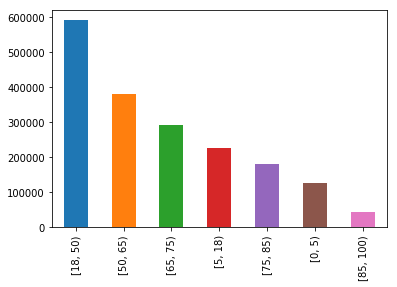

In [10]:
visualize_col(df_all, 'age')

8527    934994
0       472445
8515    326809
8516     75473
8557     20227
8657      5767
Name: race_concept_id, dtype: int64


visit_concept_id                                0        9201      9202   9203
                           race_concept_id                                    
ARI_symptoms_2_months_bool 0                 31537.0   4125.0   13448.0    2.0
                           8515              21163.0   3141.0    8511.0    8.0
                           8516               5508.0    808.0    1860.0    2.0
                           8527              56254.0   8590.0   21770.0   22.0
                           8557               1483.0    279.0     440.0    0.0
                           8657                304.0     35.0     120.0    NaN
positive                   0                   828.0     59.0      26.0    0.0
                           8515                 62.0     41.0      19.0    0.0
                           8516                 13.0      4.0       6.0    0.0
                           8527                192.0     92.0      55.0    0.0
                           8557                  3.0      7.0       2.0    0.0
                           8657                  3.0      0.0       0.0    NaN
tested                     0                  6881.0    793.0     441.0    1.0
                           8515               1213.0    461.0     306.0    0.0
                           8516                278.0    131.0      61.0    0.0
                           8527               3436.0   1370.0     834.0    2.0
                           8557                 79.0     65.0      17.0    0.0
                           8657                 18.0      6.0       9.0    NaN
total                      0                333947.0  39464.0   98994.0   40.0
                           8515             228042.0  30202.0   68525.0   40.0
                           8516              53864.0   6275.0   15319.0   15.0
                           8527             657172.0  85574.0  192107.0  141.0
                           8557              14452.0   2051.0    3720.0    4.0
                           8657               4052.0    508.0    1207.0    NaN

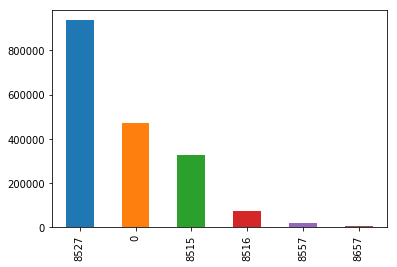

In [11]:
visualize_col(df_all, 'race_concept_id')

8532    1074003
8507     761265
0           447
Name: gender_concept_id, dtype: int64


visit_concept_id                                  0        9201      9202  \
                           gender_concept_id                                
ARI_symptoms_2_months_bool 0                      12.0      3.0       9.0   
                           8507                49856.0   7845.0   20077.0   
                           8532                66381.0   9130.0   26063.0   
positive                   0                       0.0      0.0       0.0   
                           8507                  504.0    111.0      49.0   
                           8532                  597.0     92.0      59.0   
tested                     0                      19.0      1.0       1.0   
                           8507                 4319.0   1408.0     616.0   
                           8532                 7567.0   1417.0    1051.0   
total                      0                     350.0     18.0      79.0   
                           8507               526236.0  73041.0  161902.0   
                           8532               764943.0  91015.0  217891.0   

visit_concept_id                               9203  
                           gender_concept_id         
ARI_symptoms_2_months_bool 0                    NaN  
                           8507                16.0  
                           8532                18.0  
positive                   0                    NaN  
                           8507                 0.0  
                           8532                 0.0  
tested                     0                    NaN  
                           8507                 2.0  
                           8532                 1.0  
total                      0                    NaN  
                           8507                86.0  
                           8532               154.0

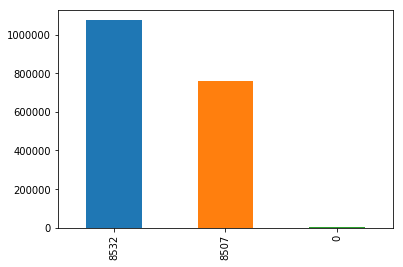

In [12]:
visualize_col(df_all, 'gender_concept_id')

38003564    1369541
38003563     281886
0            184288
Name: ethnicity_concept_id, dtype: int64


visit_concept_id                                   0       9201    9202  9203
                           ethnicity_concept_id                              
ARI_symptoms_2_months_bool 0                      10725     277    7275     1
                           38003563               21500    3725    6263     1
                           38003564               84024   12976   32611    32
positive                   0                        711       1      10     0
                           38003563                 132      58      15     0
                           38003564                 258     144      83     0
tested                     0                       5580      34     237     1
                           38003563                1197     615     206     0
                           38003564                5128    2177    1225     2
total                      0                     130099    8994   45190     5
                           38003563              202346   28005   51503    32
                           38003564              959084  127075  283179   203

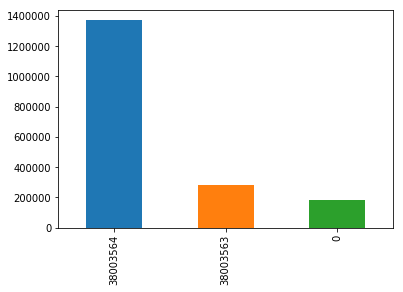

In [13]:
visualize_col(df_all, 'ethnicity_concept_id')

In [14]:
df_all['care_site_name'].value_counts().to_csv('care_counts_all_visit.csv')
df_all['care_site_name'][df_all['ARI_symptoms_2_months_bool'] == 1].value_counts().to_csv('care_counts_ari_visit.csv')
df_all['care_site_name'][df_all['tested'] == 1].value_counts().to_csv('care_counts_test_visit.csv')
df_all['care_site_name'][df_all['positive'] == 1].value_counts().to_csv('care_counts_pos_test_visit.csv')

In [15]:
def get_groupby_max(df, group_by_ls):
    df_dups_ind = df.duplicated(group_by_ls, keep=False)
    df_dups = df[:][df_dups_ind]
    df_n_dups = df[:][df_dups_ind == False]

    print(list(map(len, [df_dups_ind, df_dups, df_n_dups])))

    uniq_by_grp = [grp.sort_values(['positive', 'tested', 'care_site_name'], ascending=False).iloc[0]
        for ind, grp in df_dups.groupby(group_by_ls, sort=False)]
    df_d_dups = pd.concat(uniq_by_grp,axis=1).T

    df_uniq_by_grp = pd.concat([df_d_dups, df_n_dups],axis=0)
    print(list(map(len, [df_d_dups, df_n_dups, df_uniq_by_grp])))
    return df_uniq_by_grp

In [16]:
df_uniq_vids = get_groupby_max(df_all, ['visit_occurrence_id'])

[1835715, 32244, 1803471]
[15968, 1803471, 1819439]


In [17]:
df_uniq_vids['visit_start_date'] = df_uniq_vids['visit_start_DATETIME'].dt.date
df_uniq_person_times = get_groupby_max(df_uniq_vids, ['person_id', 'visit_start_date'])

[1819439, 1163174, 656265]
[431516, 656265, 1087781]


In [25]:
df = df_uniq_person_times.copy()
# should all be [0,1]
for elt in ['tested', 'positive', 'total', 'ARI_symptoms_2_months_bool']:
    print(df[elt].unique())

[1 0]
[0 1]
[1]
[0 1]


In [19]:
#person_id, care_site_name, visit_concept_id
len_uniq = lambda col: len(df_uniq_person_times[col].unique())
my_disp = lambda col: print('{}:{}'.format(col, len_uniq(col)))

print('total:{}'.format(len(df_uniq_person_times)))
my_disp('person_id')
my_disp('care_site_name')
my_disp('visit_occurrence_id')
pre='uniq_'
df['care_site_name'].value_counts().to_csv(pre+'care_counts_all_visit.csv')
df['care_site_name'][df['ARI_symptoms_2_months_bool'] == 1].value_counts().to_csv(pre+'care_counts_ari_visit.csv')
df['care_site_name'][df['tested'] == 1].value_counts().to_csv(pre+'care_counts_test_visit.csv')
df['care_site_name'][df['positive'] == 1].value_counts().to_csv(pre+'care_counts_pos_test_visit.csv')
print(df.isnull().sum())
df_uniq_person_times.head()

total:1087781
person_id:362631
care_site_name:1557
visit_occurrence_id:1087781
positive                            0
tested                              0
age                              1001
person_id                           0
visit_start_DATETIME                0
ARI_symptoms_2_months          989042
race_concept_id                     0
ethnicity_concept_id                0
gender_concept_id                   0
year_of_birth                       0
month_of_birth                      0
day_of_birth                        0
visit_concept_id                    0
care_site_name                  14502
value_source_value            1074428
visit_occurrence_id                 0
ARI_symptoms_2_months_bool          0
total                               0
visit_start_date                    0
dtype: int64


,positive,tested,age,person_id,visit_start_DATETIME,ARI_symptoms_2_months,race_concept_id,ethnicity_concept_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,visit_concept_id,care_site_name,value_source_value,visit_occurrence_id,ARI_symptoms_2_months_bool,total,visit_start_date
35,0,1,"[85, 100)",31449046,2020-04-01 00:00:00,None,8527,38003564,8532,1930,4,29,9201,None,Not Detected,162605931,0,1,2020-04-01
36,0,1,"[85, 100)",31449046,2020-04-11 00:00:00,None,8527,38003564,8532,1930,4,29,9201,None,Not Detected,163692693,0,1,2020-04-11
857,1,1,"[85, 100)",30121326,2020-04-06 00:00:00,True,8527,38003564,8532,1932,2,1,9201,None,Detected,163697921,1,1,2020-04-06
3304,0,1,"[85, 100)",44247408,2020-03-25 00:00:00,True,0,38003564,8532,1931,1,22,9201,None,Not Detected,163970962,1,1,2020-03-25
3634,0,1,"[85, 100)",31193960,2020-03-22 00:00:00,None,8527,38003564,8532,1932,4,12,9201,None,Not Detected,162117681,0,1,2020-03-22


[18, 50)     343355
[50, 65)     245305
[65, 75)     185990
[75, 85)     115435
[5, 18)      109438
[0, 5)        59761
[85, 100)     27496
Name: age, dtype: int64


visit_concept_id                          0        9201     9202  9203
                           age                                        
ARI_symptoms_2_months_bool [0, 5)       6599.0    334.0   6883.0   NaN
                           [18, 50)    18885.0   1652.0   7984.0  16.0
                           [5, 18)      6590.0    384.0   7061.0   0.0
                           [50, 65)    12206.0   1651.0   3968.0   8.0
                           [65, 75)     8149.0   1154.0   2176.0   2.0
                           [75, 85)     4589.0    617.0   1243.0   2.0
                           [85, 100)    1305.0    127.0    323.0   1.0
positive                   [0, 5)          7.0      0.0      0.0   NaN
                           [18, 50)      486.0     49.0     33.0   0.0
                           [5, 18)        30.0      0.0      1.0   0.0
                           [50, 65)      234.0     40.0     38.0   0.0
                           [65, 75)      125.0     16.0     11.0   0.0
                           [75, 85)       76.0     22.0      5.0   0.0
                           [85, 100)      34.0      5.0      2.0   0.0
tested                     [0, 5)        442.0     19.0      1.0   NaN
                           [18, 50)     5573.0    492.0    685.0   0.0
                           [5, 18)       519.0     15.0     21.0   0.0
                           [50, 65)     2022.0    549.0    436.0   1.0
                           [65, 75)     1039.0    265.0    160.0   1.0
                           [75, 85)      593.0    184.0     57.0   0.0
                           [85, 100)     219.0     50.0     10.0   0.0
total                      [0, 5)      35194.0   2118.0  22449.0   NaN
                           [18, 50)   253958.0  22121.0  67198.0  78.0
                           [5, 18)     69727.0   6206.0  33504.0   1.0
                           [50, 65)   181493.0  22097.0  41666.0  49.0
                           [65, 75)   138223.0  17442.0  30295.0  30.0
                           [75, 85)    86211.0   9829.0  19374.0  21.0
                           [85, 100)   21116.0   1752.0   4621.0   7.0

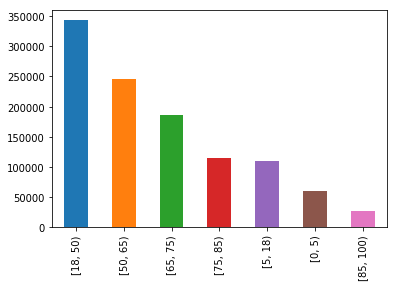

In [20]:
visualize_col(df, 'age')

8527    566576
0       270578
8515    188991
8516     46575
8557     11540
8657      3521
Name: race_concept_id, dtype: int64


visit_concept_id                                0        9201      9202   9203
                           race_concept_id                                    
ARI_symptoms_2_months_bool 0                 14046.0   1250.0    9571.0    2.0
                           8515              10220.0   1106.0    5357.0    6.0
                           8516               2984.0    255.0    1129.0    2.0
                           8527              30121.0   3214.0   13247.0   19.0
                           8557                783.0     85.0     261.0    0.0
                           8657                180.0      9.0      73.0    NaN
positive                   0                   737.0     39.0      21.0    0.0
                           8515                 57.0     31.0      14.0    0.0
                           8516                 13.0      4.0       5.0    0.0
                           8527                179.0     53.0      48.0    0.0
                           8557                  3.0      5.0       2.0    0.0
                           8657                  3.0      0.0       0.0    NaN
tested                     0                  5860.0    402.0     316.0    0.0
                           8515               1081.0    239.0     245.0    0.0
                           8516                249.0     85.0      51.0    0.0
                           8527               3123.0    806.0     738.0    2.0
                           8557                 76.0     37.0      13.0    0.0
                           8657                 18.0      5.0       7.0    NaN
total                      0                192755.0  18985.0   58805.0   33.0
                           8515             134231.0  15208.0   39526.0   26.0
                           8516              34722.0   2883.0    8959.0   11.0
                           8527             414136.0  43280.0  109047.0  113.0
                           8557               8457.0    976.0    2104.0    3.0
                           8657               2608.0    247.0     666.0    NaN

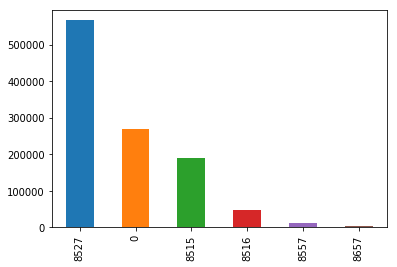

In [21]:
visualize_col(df, 'race_concept_id')

8532    630455
8507    457047
0          279
Name: gender_concept_id, dtype: int64


visit_concept_id                                  0        9201      9202  \
                           gender_concept_id                                
ARI_symptoms_2_months_bool 0                       5.0      2.0       5.0   
                           8507                24395.0   2793.0   13182.0   
                           8532                33934.0   3124.0   16451.0   
positive                   0                       0.0      0.0       0.0   
                           8507                  483.0     91.0      44.0   
                           8532                  509.0     41.0      46.0   
tested                     0                      16.0      1.0       0.0   
                           8507                 4001.0   1004.0     568.0   
                           8532                 6390.0    569.0     802.0   
total                      0                     218.0     11.0      50.0   
                           8507               326235.0  36792.0   93957.0   
                           8532               460456.0  44776.0  125100.0   

visit_concept_id                               9203  
                           gender_concept_id         
ARI_symptoms_2_months_bool 0                    NaN  
                           8507                14.0  
                           8532                15.0  
positive                   0                    NaN  
                           8507                 0.0  
                           8532                 0.0  
tested                     0                    NaN  
                           8507                 2.0  
                           8532                 0.0  
total                      0                    NaN  
                           8507                63.0  
                           8532               123.0

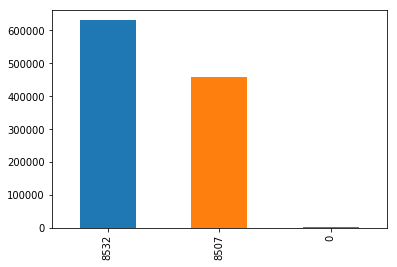

In [22]:
visualize_col(df, 'gender_concept_id')

38003564    821547
38003563    155016
0           111218
Name: ethnicity_concept_id, dtype: int64


visit_concept_id                                   0      9201    9202  9203
                           ethnicity_concept_id                             
ARI_symptoms_2_months_bool 0                       4092    111    5600     1
                           38003563               10377   1057    3888     1
                           38003564               43865   4751   20150    27
positive                   0                        632      1       8     0
                           38003563                 118     29      13     0
                           38003564                 242    102      69     0
tested                     0                       4675     17     159     0
                           38003563                1082    264     167     0
                           38003564                4650   1293    1044     2
total                      0                      76500   5496   29219     3
                           38003563              115206  12012   27771    27
                           38003564              595203  64071  162117   156

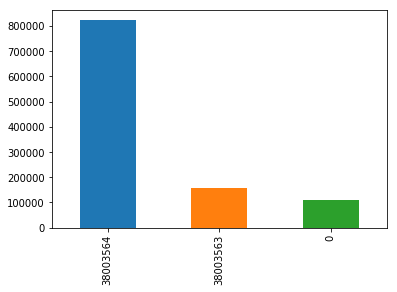

In [23]:
visualize_col(df, 'ethnicity_concept_id')